In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures) 

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330-2023s/blob/master/docs/calendar.html).**

## Imports 

In [2]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023s/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` under the data folder in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` under the data folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [3]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={autograde:2}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (40%) and `test_df` (60%) with `random_state = 123`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 40%/60% split because running cross-validation with this dataset can take a while on a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the model performance!_

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 2

In [4]:
train_df, test_df = train_test_split(census_df, test_size=0.6, random_state=123)

In [5]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [6]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values because they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [7]:
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)
train_df.shape

(13024, 15)

In [8]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 `describe()` method
rubric={autograde:5}

**Your tasks:**

1. Examine the output of `train_df.describe()` with `include='all'` argument and store it in a variable called `census_summary`.
2. What is the highest hours per week someone reported? Store it in a variable called `max_hours_per_week`.
3. What is the most frequently occurring occupation in this dataset? Store it in a variable called `most_freq_occupation`.
4. Store the column names of the columns with missing values as a list in a variable called `missing_vals_cols`. 
5. Store the column names of all numeric-looking columns as a list in a variable called `numeric_cols`.  

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 5

In [9]:
census_summary = train_df.describe(include='all')


In [10]:
max_hours_per_week = census_summary.loc['max', 'hours.per.week']


In [11]:
most_freq_occupation = census_summary.loc['top', 'occupation']


In [12]:
missing_vals_cols = train_df.columns[train_df.isnull().any()].tolist()

numeric_cols = train_df.select_dtypes(include=['int64', 'float']).columns.tolist()

numeric_cols 

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

In [13]:
# Sorting the lists for the autograder
missing_vals_cols.sort()
numeric_cols.sort()

In [14]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Visualizing features
rubric={points:5}

**Your tasks:**

1. Visualize the histograms of numeric features.  
2. From the visualizations, which features seem relevant for the given prediction task?

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 5

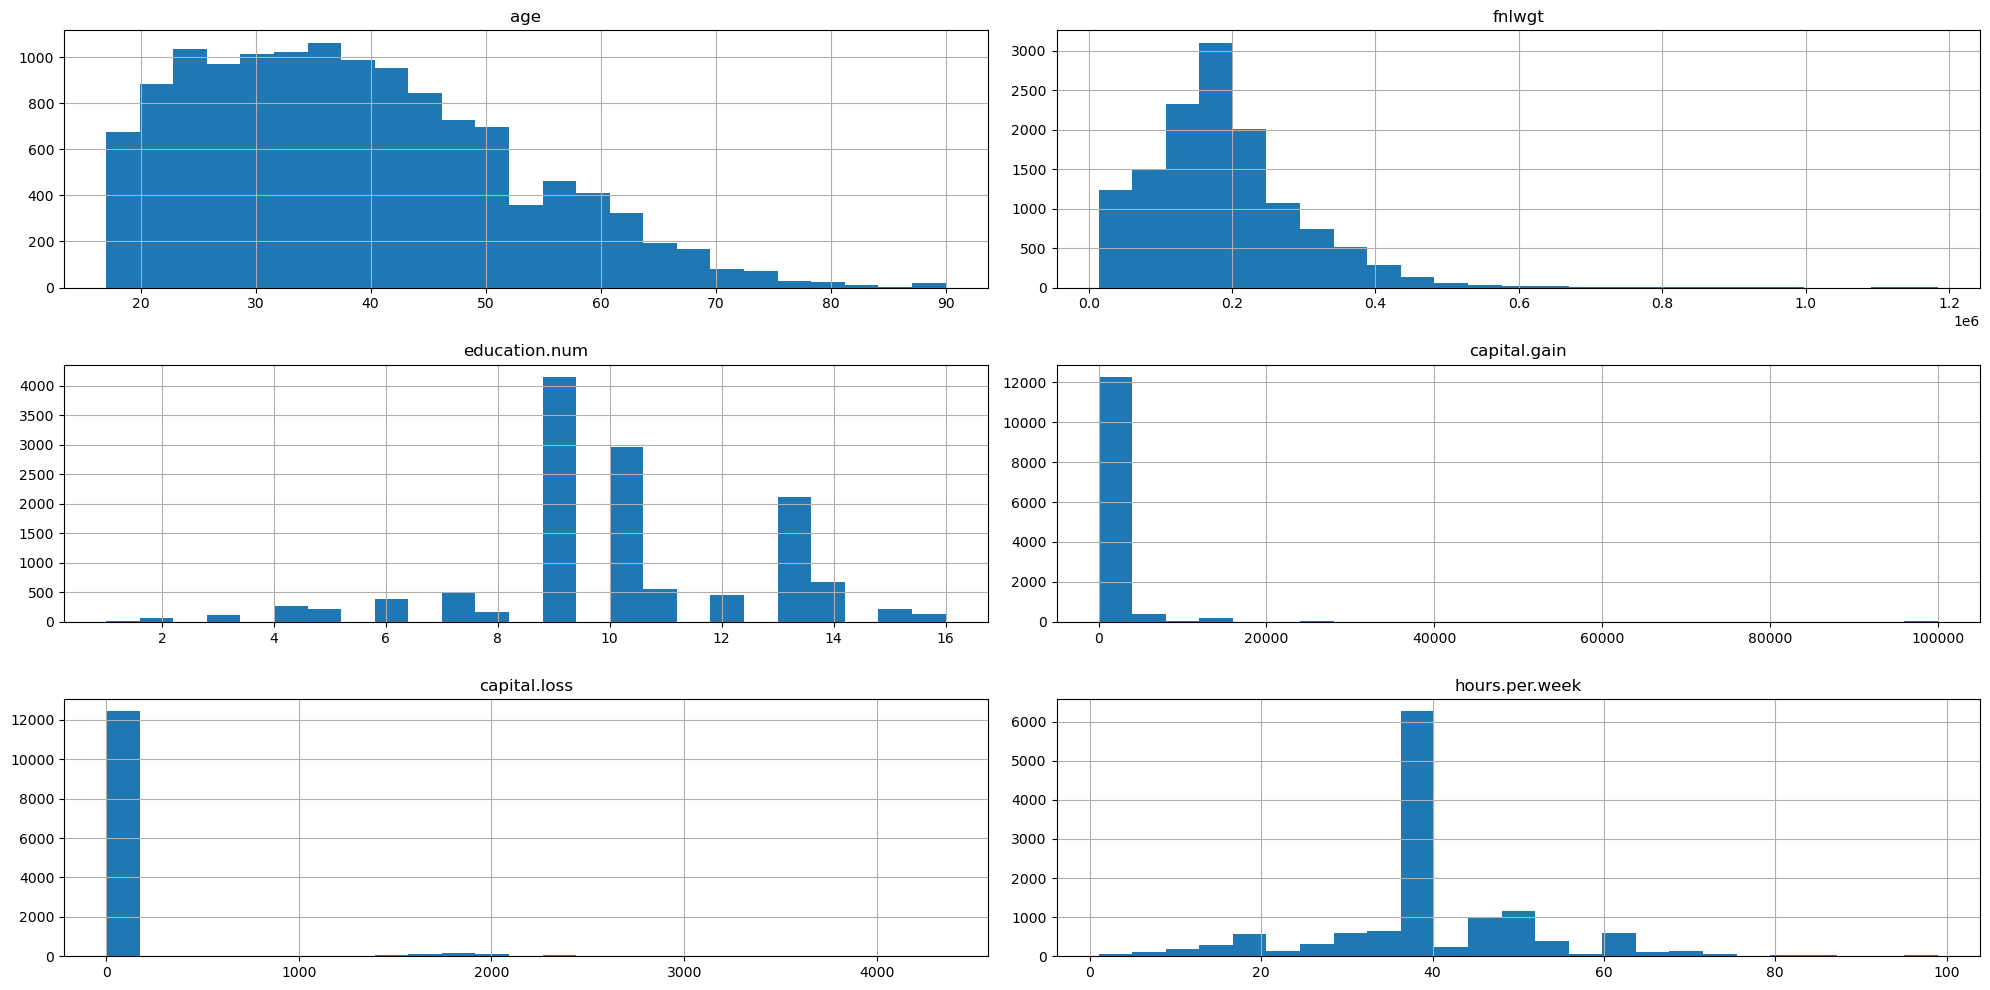

In [15]:
numeric_df = train_df.select_dtypes(include=['int64', 'float'])
numeric_df.hist(bins=25, figsize=(20,10))
plt.tight_layout()

It seems like that age, final weight (fnlwgt), education.num, and hours per week is most relevant to the given prediction task.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Identify transformations to apply
rubric={points:13}

Before passing this data to a machine learning model, we need to apply some transformations on different features. Below we are providing possible transformations which can be applied on each column in `census_df`.  

**Your tasks:**
1. Write your justification or explanation for each row in the explanation column. An example explanation is given for the age column. 

> Note: This question is a bit open-ended. If you do not agree with the provided transformation, feel free to argue your case in the explanation. That said, in this assignment, go with the transformations provided below. 

<div class="alert alert-warning">

Solution_2.3
    
</div>

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| age | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (17 to 90) is quite different compared to other numeric features.|
| workclass | imputation, one-hot encoding | workclass is a categorical feature with missing values. We impute missing values with the most frequent category, then apply one-hot encoding to convert categories into separate binary features. |
| fnlwgt | drop | fnlwgt (final weight) represents a census calculation that's not directly interpretable or useful for our predictive task, hence it's dropped. |
| education | ordinal encoding | Education represents ordered categories (e.g., HS-grad < Some-college < Bachelors), hence ordinal encoding is applied to preserve this order in numeric form. |
| education.num | drop | Education.num is a numerical representation of 'education' and is redundant since we are already considering 'education'. Therefore, it is dropped. |
| marital.status | one-hot encoding  | Marital.status is a categorical feature without order, so we apply one-hot encoding to convert each category into a separate binary feature. |
| occupation | imputation, one-hot encoding  | Occupation is a categorical feature with missing values. We impute the missing values and then apply one-hot encoding to handle this categorical feature. |
| relationship | one-hot encoding  | Relationship is a categorical feature without order, hence one-hot encoding is applied to convert each category into a separate binary feature. |
| race | drop  | Race is dropped to avoid potential biases in our model predictions. |
| sex | one-hot encoding with "binary=True" | Sex is a binary feature that only contains two categories. It's one-hot encoded and one category is dropped to prevent duplicate information. |
| capital.gain | scaling | Capital.gain is a numeric feature. Scaling is used to standardize the range of its values.  | 
| capital.loss | scaling | Capital.loss is also a numeric feature. Scaling standardizes its range of values.  |
| hours.per.week | scaling | Hours.per.week is a numeric feature, which represents the number of hours worked per week. Scaling is applied to standardize the range of its values. |
| native.country | imputation, one-hot encoding | Native.country is a categorical feature with missing values. We impute missing values and then apply one-hot encoding to handle this categorical feature. | 


<!-- END QUESTION -->

<br><br>

### 2.4 Identify feature types 
rubric={autograde:5}


**Your tasks:**
1. Based on the types of transformations you want to apply on the features, identify different feature types and store them in the variables below as lists.  

<div class="alert alert-warning">
    
Solution_2.4
    
</div>

_Points:_ 5

In [16]:
# Fill in the lists below.
numeric_features = ['age', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 'relationship', 'native.country']
ordinal_features = ['education']
binary_features = ['sex']
drop_features = ['fnlwgt', 'education.num', 'race']
target = "income"

...

Ellipsis

In [17]:
# Sorting all the lists above for the autograder
numeric_features.sort()
categorical_features.sort()
ordinal_features.sort()
binary_features.sort()
drop_features.sort()

In [18]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<br><br><br><br>

## Exercise 3: Baseline models 

### 3.1 Separating feature vectors and targets  
rubric={autograde:2}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df` and `test_df`. 

<div class="alert alert-warning">
    
Solution_3.1
    
</div>

_Points:_ 2

In [19]:
X_train = train_df.drop([target], axis=1)
y_train = train_df[target]
X_test = test_df.drop([target], axis=1)
y_test = test_df[target]


In [20]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<br><br>

### 3.2 Dummy classifier
rubric={autograde:2}

**Your tasks:**

1. Carry out 5-fold cross-validation using `scikit-learn`'s `cross_validate` function with `return_train_scores=True` and store the results as a dataframe named `dummy_df` where each row corresponds to the results from a cross-validation fold. 

<div class="alert alert-warning">
    
Solution_3.2
    
</div>

_Points:_ 2

In [21]:
# Create a dummy classifier
dummy = DummyClassifier(strategy='most_frequent', random_state=123)
# Perform 5-fold cross-validation
dummy_scores = cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True)

dummy_df =  pd.DataFrame(dummy_scores)

In [22]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Discussion
rubric={points:2}

**Your tasks:**

1. Hopefully, you were able to run cross-validation with dummy classifier successfully in the question above. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not? 

<div class="alert alert-warning">
    
Solution_3.3
    
</div>

_Points:_ 2

It won't work, there are missing values, texts, which can't be put into SVC directly, we need pre-process them

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Preprocessing
<hr>

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and a binary feature. We want to apply different transformations on different columns and therefore we need a column transformer. In this exercise, first, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer`. For example, the code below creates a `numeric_transformer` for numeric features. 

In [23]:
numeric_transformer = StandardScaler()

In the exercises below, you'll create transformers for other types of features. 

<br><br>

### 4.1 Preprocessing ordinal features
rubric={autograde:5}

**Your tasks:**

1. Create a transformer called `ordinal_transformer` for our ordinal features. 

<div class="alert alert-warning">
    
Solution_4.1
    
</div>

_Points:_ 5

In [24]:
category = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Prof-school','Assoc-voc', 'Assoc-acdm', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']

ordinal_transformer = OrdinalEncoder(categories=[category], dtype=int)

In [25]:
ordinal_transformer.get_params()['categories'][0]

['Preschool',
 '1st-4th',
 '5th-6th',
 '7th-8th',
 '9th',
 '10th',
 '11th',
 '12th',
 'HS-grad',
 'Prof-school',
 'Assoc-voc',
 'Assoc-acdm',
 'Some-college',
 'Bachelors',
 'Masters',
 'Doctorate']

In [26]:
sha1(str(ordinal_transformer.get_params()['categories'][0]).encode('utf8')).hexdigest()

'893a03d114b2af09b53247866c6eea54ebfd090f'

In [27]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<br><br>

### 4.2 Preprocessing binary features
rubric={autograde:2}

**Your tasks:**

1. Create a transformer called `binary_transformer` for our binary features.

> _Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

<div class="alert alert-warning">
    
Solution_4.2
    
</div>

_Points:_ 2

In [28]:
binary_transformer = OneHotEncoder(drop='if_binary', dtype=int)


In [29]:
grader.check("q4.2")

q4.2 results: All test cases passed!

<br><br>

### 4.3 Preprocessing categorical features
rubric={autograde:4}

In Exercise 2.3, we saw that there are 3 categorical features with missing values. So first we need to impute the missing values and then encode these features with one-hot encoding. For the purpose of this assignment, let's just have imputation as the first step for all categorical features even when they do not have missing values. This should be OK because if a feature doesn't have any missing value,  imputation won't be applied. 

If we want to apply more than one transformation on a set of features, we need to create a [`scikit-learn` `Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). For example, for categorical features we can create a `scikit-learn` `Pipeline` with first step as imputation and the second step as one-hot encoding. 

**Your tasks:**

1. Create a `sklearn` `Pipeline` using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) called `categorical_transformer` for our categorical features with two steps: `SimpleImputer` for imputation with `strategy="constant"` and `fill_value="missing"` and `OneHotEncoder` with `handle_unknown="ignore"` and `sparse=False` for one-hot encoding. 

<div class="alert alert-warning">
    
Solution_4.3
    
</div>

_Points:_ 4

In [30]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

...

Ellipsis

In [31]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<br><br>

### 4.4 Creating a column transformer. 
rubric={autograde:7}

**Your tasks:**
1. Create a `sklearn` `ColumnTransformer` named `preprocessor` using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) with the transformers defined in the previous exercises. Use the sequence below in the column transformer and add a "drop" step for the `drop_features` in the end.  
    - `numeric_transformer`
    - `ordinal_transformer`
    - `binary_transformer`
    - `categorical_transformer`
2. Transform the data by calling `fit_transform` on the training set and save it as a dataframe in a variable called `transformed_df`. How many new columns have been created in the preprocessed data in comparison to the original `X_train`? Store the difference between the number of columns in `transformed_df` and `X_train` in a variable called `n_new_cols`. 

<div class="alert alert-warning">
    
Solution_4.4
    
</div>

_Points:_ 7

In [32]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [33]:
transformed_data = preprocessor.fit_transform(X_train)
transformed_df = pd.DataFrame(transformed_data)

n_new_cols = transformed_df.shape[1] - X_train.shape[1]

In [34]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<br><br><br><br>

## Exercise 5: Building models 

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Use it to keep track of your results. 

In [35]:
results_dict = {}  # dictionary to store all the results

In [36]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Below I'm showing an example where I call `mean_std_cross_val_scores` with `DummyClassifier`. The function calls `cross_validate` with the passed arguments and returns a series with mean cross-validation results and std of cross-validation. When you train new models, you can just add the results of these models in `results_dict`, which can be easily converted to a dataframe so that you can have a table with all your results. 

In [37]:
# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 123)
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.019 (+/- 0.003),0.007 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)


<br><br>

<!-- BEGIN QUESTION -->

### 5.1 Trying different classifiers
rubric={points:10}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 4.4 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline and get the mean cross-validation scores with std by calling the `mean_std_cross_val_scores` function above. 
    - Store the results in a dataframe called `income_pred_results_df` with the model names in the `models` dictionary below as the index and each row representing results returned by `mean_std_cross_val_scores` function above. In other words, `income_pred_results_df` should look similar to the `results_df` dataframe above with more rows for the models below. 
    
> This might take a while to run. Be patient! 

In [38]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}

<div class="alert alert-warning">
    
Solution_5.1
    
</div>

_Points:_ 10

In [39]:
# Iterate over the models and compute cross-validation scores
for model_name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[model_name] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)
 
income_pred_results_df = pd.DataFrame(results_dict).T
income_pred_results_df
 


,fit_time,score_time,test_score,train_score
dummy,0.019 (+/- 0.003),0.007 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.055 (+/- 0.003),0.008 (+/- 0.001),0.814 (+/- 0.012),0.987 (+/- 0.001)
kNN,0.028 (+/- 0.003),0.080 (+/- 0.013),0.836 (+/- 0.008),0.883 (+/- 0.002)
RBF SVM,1.584 (+/- 0.073),0.506 (+/- 0.026),0.852 (+/- 0.005),0.855 (+/- 0.002)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.2 Discussion 
rubric={points:5}

**Your tasks:**

1. Examine the train and validation accuracies and `fit` and `score` times for all the models in the results above. How do the validation accuracies compare to the `DummyClassifier` model? Which model has the best validation accuracy? Which model is the fastest one? Which model is overfitting the most and the least?  


<div class="alert alert-warning">
    
Solution_5.2
    
</div>

_Points:_ 5

Based on the provided results, we can see

- Validation Accuracies: The validation accuracies for all models are higher than the DummyClassifier model, indicating that all models perform better than the baseline. The model with the best validation accuracy is the RBF SVM, with an accuracy of 0.852 (+/- 0.005).
- Fastest Model: The model with the fastest fit and score times is the kNN model. It has a fit time of 0.027 (+/- 0.003) and a score time of 0.075 (+/- 0.015).
- Overfitting: The model that seems to be overfitting the most is the Decision Tree model. It has a high train accuracy of 0.987 (+/- 0.001) but a lower validation accuracy of 0.814 (+/- 0.012), indicating potential overfitting. On the other hand, the RBF SVM model shows less overfitting with a train accuracy of 0.855 (+/- 0.002) and a slightly higher validation accuracy of 0.852 (+/- 0.005).

In summary:
- The RBF SVM model has the best validation accuracy.
- The kNN model is the fastest.
- The Decision Tree model appears to be overfitting the most, while the RBF SVM model shows less overfitting.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.3 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice, you'll carry out hyperparameter optimization for all different hyperparameters of the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter, namely `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` below: 
    - Create a pipeline object with two steps: preprocessor from 4.4 and `SVC` classifier with the `C` value.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Store it in a variable called `best_C`. (Since this question is not autograded, please store the value directly as a number, something like `best_C = 0.001`, if `C = 0.001` is giving you the best CV score.) Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this will take a while. Please be patient. 

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": np.logspace(-1, 2, 4)}

results_dict = {"C":[], "mean_cv_score": []} 

for C in param_grid["C"]:
    pipeline = make_pipeline(preprocessor, SVC(C=C))
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # perform cross-validation
    mean_score = np.mean(scores)                                # compute mean cross-validation accuracy
    results_dict["C"].append(C)
    results_dict["mean_cv_score"].append(mean_score)


<div class="alert alert-warning">
    
Solution_5.3
    
</div>

_Points:_ 10

In [41]:
results_df = pd.DataFrame(results_dict)
print(results_df)

       C  mean_cv_score
0    0.1       0.838298
1    1.0       0.852350
2   10.0       0.857571
3  100.0       0.859567


In [42]:
best_index = np.argmax(results_dict["mean_cv_score"])

best_C = results_dict["C"][best_index]

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 6: Evaluating on the test set 
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise, you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 6.1 Scoring on the unseen test set 
rubric={autograde:4}

**Your tasks:**

1. Create a pipeline named `final_pipeline` with the preprocessor from 4.4 as the first step and the best performing SVC model from 5.4 as the second step. 
2. Train the pipeline on the entire training set `X_train` and `y_train`. 
3. Score the pipeline on `X_test` and `y_test` and store the score in a variable called `test_score`.  

<div class="alert alert-warning">
    
Solution_6.1
    
</div>

_Points:_ 4

In [ ]:
final_pipeline = make_pipeline(preprocessor, SVC(C=best_C))

final_pipeline.fit(X_train, y_train)

test_score = final_pipeline.score(X_test, y_test)

In [ ]:
grader.check("q6.1")

<br><br><br><br>

## Exercise 7: Short answer questions

<!-- BEGIN QUESTION -->

### 7.1 kNNs toy example
rubric={points:3}

Suppose you want to get predictions using the $k$-nearest neighbour algorithm on the toy dataset below. 

$$ X = \begin{bmatrix}5 & 2\\4 & -2\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

Suppose you are given a new data point $x=\begin{bmatrix} 0\\0\end{bmatrix}$.  

1. What would the model predict when $k=1$?
2. What would the model predict when $k=3$?
3. What would the model predict when $k=3$ if we were doing regression rather than classification? 

_Points:_ 3

when $k=1$
The nearest neighbor to $x$ is the second data point $[2, 2]$, which has a label of 1.
Therefore, when $k = 1$, the model would predict 1 for the new data point $x$.

when $k=3$
The three nearest neighbors to $x$ are the second data point $[4, -2]$ (label 0), the third data point $[2, 2]$ (label 1), and the fifth data point $[5, 2]$ (label 0).
Among the three neighbors, the majority label is 0.
Therefore, when $k = 3$, the model would predict 0 for the new data point $x$.

When k = 3 for regression:
In regression, instead of selecting the majority label, we take the average value of the labels of the k nearest neighbors.
The labels of the three nearest neighbors are 0, 1, and 0.
The average value of these labels is $(0 + 1 + 0) / 3 = 1/3$.
Therefore, when $k = 3$ for regression, the model would predict 2/3 for the new data point $x$.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 7.2 Preprocessing
rubric={points:8}

1. What is the problem with calling `fit_transform` on your test data with `StandardScaler`?
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. What are two advantages of using sklearn Pipelines? 
4. When is it appropriate to use sklearn `ColumnTransformer`? 

_Points:_ 8

1. The problem with calling `fit_transform` on test data with `StandardScaler` is that it leads to inconsistent scaling between the training and test data, introducing data leakage and potentially producing incorrect predictions.

2. Following the Golden Rule is important because it ensures unbiased evaluation of a model's performance on unseen data. Violating the Golden Rule by using test data during training can result in overfitting and a worse classifier due to the lack of generalization ability.

3. Two advantages of using sklearn Pipelines are:
   - Convenience and Readability: Pipelines allow for the seamless integration of multiple preprocessing steps and the final model into a single object, enhancing code organization and readability.
   - Data Leakage Prevention: Pipelines ensure that all preprocessing steps are applied solely to the training data during cross-validation and deployment, preventing information from the test data or future data from influencing the training process and leading to more reliable model evaluation and generalization.

4. sklearn `ColumnTransformer` is appropriate when you have a dataset with different types of features that require distinct preprocessing steps. It allows for the application of specific transformations to specific subsets of features, streamlining the preprocessing workflow and maintaining consistency and efficiency in handling diverse feature types.

<!-- END QUESTION -->

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](img/eva-well-done.png)

